# Docs, sources

https://rufat.be/triangle/index.html - library used for triangulation

https://stackoverflow.com/a/50974391/10093288 - this function can be used for drawing circles through three points

https://en.wikipedia.org/wiki/Constrained_Delaunay_triangulation - Constrained Delaunay triangulation (definition)

https://en.wikipedia.org/wiki/Circumscribed_circle - properties of circumscribed circle (theory)

In [23]:
!pip install triangle
!pip install more-itertools

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itr
import triangle as tr

### Defining input data 

In [10]:
polygonVertices = np.array([[0, 1], [-1, 0], [-3, 0], [0, 3], [3, 0], [1, 0]])
polygonHolesPoints = np.array([[0,0]])
polygonFrame = np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,0]])

inputPolygonInfo = dict(vertices=polygonVertices, 
                        holes=polygonHolesPoints, #not reqiered parameter in our case
                        segments=polygonFrame)

# Triagulation options
**D** - Conforming Delaunay: use this switch if you want all triangles in the mesh to be Delaunay, and not just constrained Delaunay; or if you want to ensure that all Voronoi vertices lie within the triangulation.

**p** - Triangulates a Planar Straight Line Graph.


#### Styles

In [36]:
circleBorderColor = '0.75'
circleInnerColor = "none"

### Utility functions

In [13]:
def define_circle(p1, p2, p3, epsilon = 1.0e-6):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    
    determinant = ((p1[0] - p2[0]) * (p2[1] - p3[1]) 
                 - (p2[0] - p3[0]) * (p1[1] - p2[1]))

    if abs(determinant) < epsilon:
        return (None, np.inf)

    # Center of the circle
    centerX = (bc * (p2[1] - p3[1]) 
             - cd * (p1[1] - p2[1])) / determinant
    centerY = (cd * (p1[0] - p2[0]) 
             - bc * (p2[0] - p3[0])) / determinant

    radius = np.sqrt((centerX - p1[0]) ** 2 + (centerY - p1[1]) ** 2)
    return ((centerX, centerY), radius) 

### Triangulating and showing results

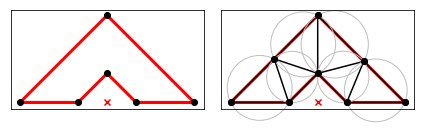

In [40]:
triangulationResult = tr.triangulate(inputPolygonInfo, opts='Dp')
tr.compare(plt, inputPolygonInfo, triangulationResult)

vertecies = triangulationResult['vertices']
triangles = triangulationResult['triangles']

for triangle in triangles:
    vertex1 = vertecies[triangle[0]]
    vertex2 = vertecies[triangle[1]]
    vertex3 = vertecies[triangle[2]]
    center, radius = define_circle(vertex1, vertex2, vertex3)
    if center is not None:
        circle = plt.Circle(center, radius, clip_on = False)
    
        circle.set_edgecolor(circleBorderColor)
        circle.set_facecolor(circleInnerColor)
    
        plt.gcf().gca().add_artist(circle)


#TODO: draw circles for all triangles of the triangulated polygon
#     (choose points from tringulationResult)

